In [1]:
import numpy as np
from numpy import linalg
%matplotlib inline
import matplotlib.pyplot as plt
import mpl_toolkits
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.colors as colors
import rosbag
import glob
from urdf_parser_py.urdf import URDF
from pykdl_utils.kdl_parser import kdl_tree_from_urdf_model
from pykdl_utils.kdl_kinematics import KDLKinematics
import time
from IPython import display
import random
from sklearn.neighbors import NearestNeighbors

In [2]:
data_path = './Robot_ViconNovember/'

#loading the saved lists of vicon databags
vicon_dylist = []
vicon_dyTime = []
for i in range(9):     
    vicon_dy = np.load(data_path+'vicon_dynaPosArr%d.npy'%i)
    vicon_dylist.append(vicon_dy)  
    vicon_time = np.load(data_path+'viconbag_time_dyna%d.npy'%i)
    vicon_dyTime.append(vicon_time)
vicon_endeff_subsetbag1 = vicon_dylist[1]
vicon_Time_subsetbag1 = vicon_dyTime[1]

joints_list_dyna = []
jaTime_list_dyna = []
turret_list_dyna = []
markertag_list_dyna = []
tag_time_list_dyna = []
for i in range(9):
    RobotJoints_dy = np.load(data_path+'ja_array_dyna%d.npy'%i)
    joints_list_dyna.append(RobotJoints_dy)
    jaTime = np.load(data_path+'robotbag_Jointstime_dyna%d.npy'%i)
    jaTime_list_dyna.append(jaTime) 
    turret_joints = np.load(data_path+'ja_turretCam_dyna%d.npy'%i)
    turret_list_dyna.append(turret_joints)
    marker_dyn = np.load(data_path+'robot_dynaPosArr%d.npy'%i)
    markertag_list_dyna.append(marker_dyn)
    tag_time = np.load(data_path+'robotbag_Tagtime_dyna%d.npy'%i)
    tag_time_list_dyna.append(tag_time)
robot_joints_subsetbag1 = joints_list_dyna[1]
turret_joints_subsetbag1 = turret_list_dyna[1]
markerTag_ee_subsetbag1 = markertag_list_dyna[1]
ja_Time_subsetbag1 = jaTime_list_dyna[1]
tag_time_subsetbag1 = tag_time_list_dyna[1]
#transform
camera_angles = np.stack((robot_joints_subsetbag1[:,0],turret_joints_subsetbag1)).T

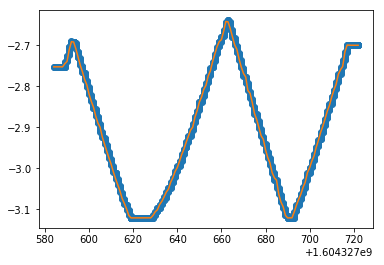

In [4]:
#interpolating kinee and april_tag ee
import matplotlib.pyplot as plt
from scipy import interpolate
####vicon  time
x_jointtime = ja_Time_subsetbag1
#vicon data on each axis
y_joint1 = robot_joints_subsetbag1[:,0]
y_joint2 = robot_joints_subsetbag1[:,1]
y_joint3 = robot_joints_subsetbag1[:,2]
y_joint4 = robot_joints_subsetbag1[:,3]
##function of vicon data and its time
f_1 = interpolate.interp1d(x_jointtime, y_joint1, kind='nearest',fill_value="extrapolate")
f_2 = interpolate.interp1d(x_jointtime, y_joint2, kind='nearest',fill_value="extrapolate")
f_3 = interpolate.interp1d(x_jointtime, y_joint3, kind='nearest',fill_value="extrapolate")
f_4 = interpolate.interp1d(x_jointtime, y_joint4, kind='nearest',fill_value="extrapolate")
#robot time
x_tagtime = tag_time_subsetbag1
##use robot time and the function of vicon to get the new interpolated vicon data
ynew_j1 = f_1(x_tagtime)   # use interpolation function returned by `interp1d`
ynew_j2 = f_2(x_tagtime)
ynew_j3 = f_3(x_tagtime)
ynew_j4 = f_4(x_tagtime)
plt.plot(x_jointtime, y_joint4, 'o', x_tagtime, ynew_j4, '-')
plt.show()
joints_interpolated_inTag = np.column_stack((ynew_j1,ynew_j2,ynew_j3,ynew_j4)) 
# joints_interpolated_inTag.shape

In [7]:
def kinematics_endeff_interpd(joint_angles_interpd):
    robot = URDF.from_xml_file('robotMarker.urdf')
    kdl_kin_ee_dy = KDLKinematics(robot,'base_link','marker_link')
    ee_list_dy = []
    for joints in joint_angles_interpd:
        pose_ee_fkmatrix = kdl_kin_ee_dy.forward(joints[:4])
        ee_list_dy.append(pose_ee_fkmatrix[0:3,3])
        z = np.squeeze(np.array(ee_list_dy))
    return z
ee_iterpdjoints = kinematics_endeff_interpd(joints_interpolated_inTag)

In [8]:
#this one also computes the end-effector prior
def jointsTo_endeff(joint_angles):
    robot = URDF.from_xml_file('robotMarker.urdf')
    kdl_kin_ee_dy = KDLKinematics(robot,'base_link','marker_link')
    
    ee_list_dy = []
    for joints in joint_angles:
        ee_list_dy.append(kdl_kin_ee_dy.forward(joints)) 
    return  ee_list_dy
# z = jointsTo_endeff([robot_joints_subsetbag1[0]])
# z

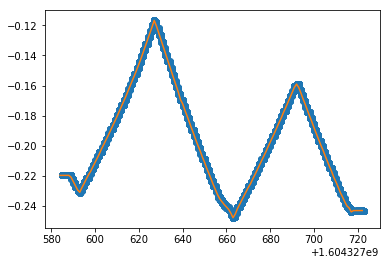

In [9]:
#interpolate datatag_time_subsetbag1 = tag_time_list_dyna[1]
#transform
camera_angles = np.stack((robot_joints_subsetbag1[:,0],turret_joints_subsetbag1)).T
import matplotlib.pyplot as plt
from scipy import interpolate
####vicon  time
x_Vtime = vicon_Time_subsetbag1
#vicon data on each axis
y_Viconx = vicon_endeff_subsetbag1[:,0]
y_Vicony = vicon_endeff_subsetbag1[:,1]
y_Viconz = vicon_endeff_subsetbag1[:,2]
##function of vicon data and its time
f_x = interpolate.interp1d(x_Vtime, y_Viconx, kind='nearest',fill_value="extrapolate")
f_y = interpolate.interp1d(x_Vtime, y_Vicony, kind='nearest',fill_value="extrapolate")
f_z = interpolate.interp1d(x_Vtime, y_Viconz, kind='nearest',fill_value="extrapolate")
#robot time
x_tagtime = tag_time_subsetbag1
##use robot time and the function of vicon to get the new interpolated vicon data
ynew_Viconx = f_x(x_tagtime)   # use interpolation function returned by `interp1d`
ynew_Vicony = f_y(x_tagtime)
ynew_Viconz = f_z(x_tagtime)
plt.plot(x_Vtime, y_Viconx, 'o', x_tagtime, ynew_Viconx, '-')
plt.show()
vicon_interpolated = np.column_stack((ynew_Viconx,ynew_Vicony,ynew_Viconz)) 

In [12]:
#manually aligning the vicon data to robot frame
def manualVicon(vicon_intrpddata):
    theta = np.radians(269)
    translation = [0.00,0.004,0.005]
    Rot_mat = np.array([[np.cos(theta), -np.sin(theta), 0],[np.sin(theta), np.cos(theta), 0],[0,0,1]])
    vicon_trans = (np.dot(Rot_mat,((vicon_intrpddata).T)).T) - translation
    return vicon_trans
transformedvicon = manualVicon(vicon_interpolated )

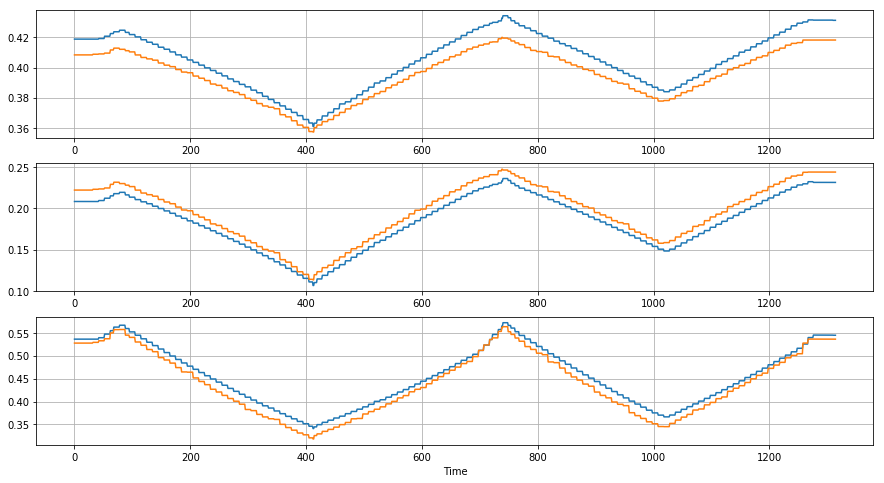

In [13]:
fig, axs = plt.subplots(3,figsize =(15,8))
plt.xlabel('Time')
axs[0].grid()
axs[1].grid()
axs[2].grid()

#Plot the predicted end effector prior"""""
axs[0].plot(transformedvicon[:,0]) 
axs[0].plot(ee_iterpdjoints[:,0])

axs[1].plot(transformedvicon[:,1]) 
axs[1].plot(ee_iterpdjoints[:,1])

axs[2].plot(transformedvicon[:,2]) 
axs[2].plot(ee_iterpdjoints[:,2])
plt.show()

In [14]:
def best_fit_transform(A, B):
    '''
    Calculates the least-squares best-fit transform that maps corresponding points A to B in m spatial dimensions
    Input:
      A: Nxm numpy array of corresponding points
      B: Nxm numpy array of corresponding points
    Returns:
      T: (m+1)x(m+1) homogeneous transformation matrix that maps A on to B
      R: mxm rotation matrix
      t: mx1 translation vector
    '''
    
    #assert A.shape == B.shape  ####commented  all the assert statements 
                                ####coz they were gving me shape erros whereas the datasets shapes were the same,

    # get number of dimensions
    m = A.shape[1]

    # translate points to their centroids
    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)
    AA = A - centroid_A
    BB = B - centroid_B

    # rotation matrix
    H = np.dot(AA.T, BB)
    U, S, Vt = np.linalg.svd(H)
    R = np.dot(Vt.T, U.T)

    # special reflection case
    if np.linalg.det(R) < 0:
       Vt[m-1,:] *= -1
       R = np.dot(Vt.T, U.T)

    # translationicpTransformationTrain = icp(kinematicsEE_transTrain,vicon_train,
    #init_pose=None, max_iterations=100000, tolerance=1e-9)
    t = centroid_B.T - np.dot(R,centroid_A.T)

    # homogeneous transformation
    T = np.identity(m+1)
    T[:m, :m] = R
    T[:m, m] = t

    return T, R, t


def nearest_neighbor(src, dst):
    '''
    Find the nearest (Euclidean) neighbor in dst for each point in src
    Input:
        src: Nxm array of points
        dst: Nxm array of points
    Output:
        distances: Euclidean distances of the nearest neighbor
        indices: dst indices of the nearest neighbor
    '''
    
    #assert src.shape == dst.shape

    neigh = NearestNeighbors(n_neighbors=1)
    neigh.fit(dst)
    distances, indices = neigh.kneighbors(src, return_distance=True)
    return distances.ravel(), indices.ravel()


def icp(A, B, init_pose=None, max_iterations=20, tolerance=0.001):
    '''
    The Iterative Closest Point method: finds best-fit transform that maps points A on to points B
    Input:
        A: Nxm numpy array of source mD points
        B: Nxm numpy array of destination mD point
        init_pose: (m+1)x(m+1) homogeneous transformation
        max_iterations: exit algorithm after max_iterations
        tolerance: convergence criteria
    Output:
        T: final homogeneous transformation that maps A on to B
        distances: Euclidean distances (errors) of the nearest neighbor
        i: number of iterations to converge
    '''
    
    #assert A.shape == B.shape

    # get number of dimensions
    m = A.shape[1]

    # make points homogeneous, copy them to maintain the originals
    src = np.ones((m+1,A.shape[0]))
    dst = np.ones((m+1,B.shape[0]))
    src[:m,:] = np.copy(A.T)
    dst[:m,:] = np.copy(B.T)

    # apply the initial pose estimation
    if init_pose is not None:
        src = np.dot(init_pose, src)

    prev_error = 0

    for i in range(max_iterations):
        # find the nearest neighbors between the current source and destination points
        distances, indices = nearest_neighbor(src[:m,:].T, dst[:m,:].T)

        # compute the transformation between the current source and nearest destination points
        T,_,_ = best_fit_transform(src[:m,:].T, dst[:m,indices].T)

        # update the current source
        src = np.dot(T, src)

        # check error
        mean_error = np.mean(distances)
        if np.abs(prev_error - mean_error) < tolerance:
            break
        prev_error = mean_error

    # calculate final transformation
    T,_,_ = best_fit_transform(A, src[:m,:].T)

    return T #,i

In [15]:
icpTransformation = icp(transformedvicon,ee_iterpdjoints, 
                        init_pose=None, max_iterations=100000, tolerance=1e-9)

In [16]:
homo_vicon_trans = np.c_[ transformedvicon, np.ones(len(transformedvicon)) ] 
viconICP_inRobot = (np.dot(icpTransformation,homo_vicon_trans.T)).T
viconInRobotFrame = viconICP_inRobot[:,:3]

(4,)


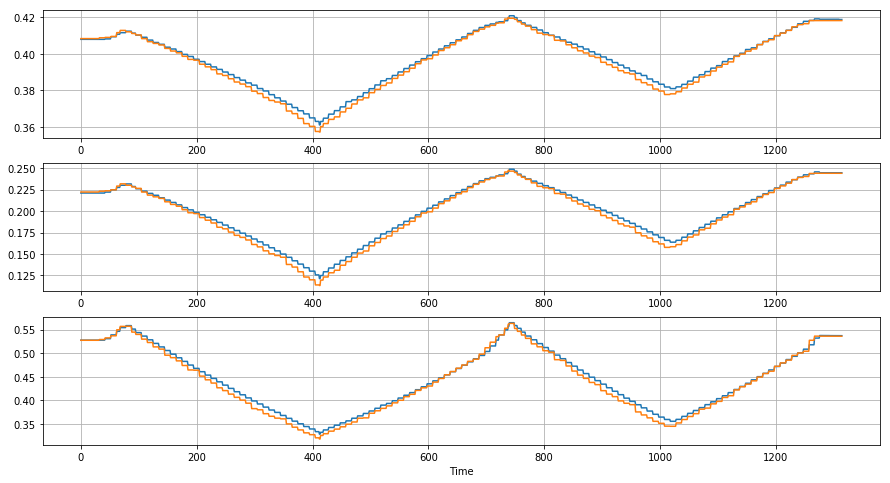

In [17]:
fig, axs = plt.subplots(3,figsize =(15,8))
plt.xlabel('Time')
axs[0].grid()
axs[1].grid()
axs[2].grid()

#Plot the predicted end effector prior"""""
axs[0].plot(viconInRobotFrame[:,0]) 
axs[0].plot(ee_iterpdjoints[:,0])

axs[1].plot(viconInRobotFrame[:,1]) 
axs[1].plot(ee_iterpdjoints[:,1])

axs[2].plot(viconInRobotFrame[:,2]) 
axs[2].plot(ee_iterpdjoints[:,2])
plt.show()

In [18]:

tag_time_subsetbag1 = tag_time_list_dyna[1]


In [19]:
#computing the sigma points
def sigma_points(mu,cov,n,lam):
#computes the cholesky decomposition of matrix square root A, 
#which assumes it to be a symmetric and positive definite matrix
    chol_A = np.linalg.cholesky((n+lam)*cov)
    sigma_pointx = np.zeros((7,len(mu)))
    sigma_pointx[0,:] = mu
    for i in range(3):
        #print(i)
        sigma_pointx[i+1,:] =  mu + chol_A[:,i]
    for i in range(3):
        sigma_pointx[i+4,:] =  mu - chol_A[:,i]
    return sigma_pointx

In [20]:
#assigning weights to the computed sigmas
def weight_sigma(al,n,k,b,lam):
    c = n + lam
    w_mu = np.zeros((2 * n + 1,1))
    w_mu[0,0] = lam / c
    
    w_cov = np.zeros((2 * n + 1,1))
    w_cov[0,0] = w_mu[0,0] + (1 - al**2 + b)
    for i in range(6):
        w_mu[i+1,0] = 0.5/c
        w_cov[i+1,0] = 0.5/c
    return w_mu,w_cov

In [21]:
#estimating the resulting posterior distribution of the end-effector.
def estimate_distri(transformedpoints,weight_mean,weight_cov,n,resh):
    mu_Keeprime = np.zeros((resh,1))
    cov_Keeprime = np.zeros((resh,resh))
    for i in range(2*(n) + 1):
        mu_Keeprime = mu_Keeprime + weight_mean[i]*transformedpoints[i,:].reshape(resh,1)
    for i in range(2*(n) + 1):
        cov_Keeprime = cov_Keeprime + weight_cov[i]*(transformedpoints[i,:].reshape(resh,1) 
                    - mu_Keeprime).dot((transformedpoints[i,:].reshape(resh,1) - mu_Keeprime).T)
    return mu_Keeprime, cov_Keeprime

In [22]:
#computing the transformation from the base to the turretCam_link for camera transformation relative to the ee
def turretTransform(angle):
    robot = URDF.from_xml_file('robotMarker.urdf')
    
    kdl_kin_turretUP_dy = KDLKinematics(robot,'base_link','turret_camera_link')
    
    return kdl_kin_turretUP_dy.forward(angle)

In [23]:
#Camera model that projects a point from 3D to image plane
def rtmapping(X_world,camTransform):
    K = np.matrix([[136.848632, 0.0, 128.029255, 0],[0.0, 138.204089, 86.254287, 0],[ 0.0, 0.0, 1.0, 0.0]]) 
    P = K * camTransform 
    x_im = P.dot(np.concatenate((X_world, np.array([1])), axis=0))
    return x_im

In [24]:
#converts the point to 2d
def endEffecImage2d(ee_ImaHomo):
    for i in range(len(ee_ImaHomo )):
        x= ee_ImaHomo[:,0]/ee_ImaHomo[:,2]
        y= ee_ImaHomo[:,1]/ee_ImaHomo[:,2]
        xx,yy = x.reshape(len(ee_ImaHomo),1),y.reshape(len(ee_ImaHomo),1)
    return np.hstack((xx,yy))

In [25]:
#Unscented Transform parameters                                    
n_dim = 3
alpha = 0.5
kappa = 0
lamda = (((alpha)**2) * (n_dim + kappa) - n_dim)
beta = 2.0
resh1 = 3
resh2 = 2
for t in range(11):
    mu_theta = joints_interpolated_inTag[t]
    camera_angle = camera_angles[t]
    marker_pos = markerTag_ee_subsetbag1[t]

In [26]:
# #Propagate 3D marker measurement through camera (no rotation and translation)
sensordata_z = rtmapping(marker_pos, np.eye(4))
sensordata_in2d = endEffecImage2d(sensordata_z)

#measuremnt noise in pixels
m_noiseQ = 150 *np.eye(2,dtype=float)

In [27]:
ee_mean_prior = []
ee_cov_prior = []
#for t in range(11):
for t in range(len(markerTag_ee_subsetbag1)):
    # Define angle uncertainty
    cov_theta = np.eye(4)*0.01
    #mu_theta = robot_joints_subsetbag1[t]
    mu_theta = joints_interpolated_inTag[t]

    #Generate sigma joint angle points
    sigma_angles = sigma_points(mu_theta,cov_theta,n_dim,lamda)

    #Calculate sigma joint angle weights
    wsm, wsc = weight_sigma(alpha,n_dim,kappa,beta,lamda) 

    #propagating the sigma angles thru fk
    fbase_eeMatrices = jointsTo_endeff(sigma_angles)
    fbase_poses = []
    for fbase in fbase_eeMatrices:
        fbase_poses.append(fbase[0:3,3])
        fbase_posesArr = np.array(fbase_poses)
    fbase_posesArrshaped = ((np.reshape(fbase_posesArr, (7, 3))))

    #Estimating the new Gaussian distribution of the end-effector space
    mu_xee, covmat_xee = estimate_distri(fbase_posesArrshaped,wsm, wsc,n_dim,3)
    mu_xee = mu_xee.reshape(3,)
    ee_mean_prior.append(mu_xee)
    ee_cov_prior.append(covmat_xee)
ee_mean_prior_arr = np.array(ee_mean_prior)


cov_diags_x_prior = []
for cov_prx in ee_cov_prior:
    all_diags_x_prior = ((np.diag(cov_prx))[0])
    cov_diags_x_prior.append(all_diags_x_prior)
cov_diags_arr_x_prior = (np.array(cov_diags_x_prior))
cov_x_prior=  cov_diags_arr_x_prior.reshape(len(cov_diags_arr_x_prior),)

cov_diags_y_prior = []
for cov_pry in ee_cov_prior:
    all_diags_y_prior= ((np.diag(cov_pry))[1])
    cov_diags_y_prior.append(all_diags_y_prior)
cov_diags_arr_y_prior= (np.array(cov_diags_y_prior))
cov_y_prior=  cov_diags_arr_y_prior.reshape(len(cov_diags_arr_y_prior),)

cov_diags_z_prior = []
for cov_prz in ee_cov_prior:
    all_diags_z_prior = ((np.diag(cov_prz))[2])
    cov_diags_z_prior.append(all_diags_z_prior)
cov_diags_arr_z_prior= (np.array(cov_diags_z_prior))
cov_z_prior =  cov_diags_arr_z_prior.reshape(len(cov_diags_arr_z_prior),)
    
ee_cov_all_prior = np.column_stack((cov_x_prior,cov_y_prior,cov_z_prior))


In [28]:
robot = URDF.from_xml_file('robotMarker.urdf')
links = [rl.name for rl in robot.links]
kdl_kin_cam_dy = KDLKinematics(robot,'base_link','turret_link') #maybe up to 'turretCam_link'

In [29]:
'this is the transformation we had for camera ,which only included turret joint'

def camera_transform(joint_angles):
    robot = URDF.from_xml_file('robotMarker.urdf')
    links = [rl.name for rl in robot.links]
    #print(links)
    kdl_kin_cam_dy = KDLKinematics(robot,'base_link','turret_link') #maybe up to 'turretCam_link'
    print(kdl_kin_cam_dy.get_joint_names())
    cam_list_dy = []
    for joints in joint_angles:
        cam_list_dy.append(kdl_kin_cam_dy.forward(joints[:1]))
    return cam_list_dy


In [30]:
camHTH = camera_transform([mu_theta])
camHTH = ((np.array(camHTH[0])).reshape(4,4))


['turret']


In [31]:
#get the transformation from base to end effector (using a single point)
eeTransformation = jointsTo_endeff([mu_theta])
#ee_tf in the camera frame, invert baseTOee then combine with baseTocam_tf
ee_inCamFrame = np.dot(np.linalg.inv(eeTransformation),camHTH)
m_noiseQ = 150 *np.eye(2,dtype=float)

ee_image_mu = []
ee_image_uncertain = []
sensor_eeIn2d = []
for t in range(len(ee_mean_prior)):
    camera_angle = camera_angles[t]
    marker_pos = markerTag_ee_subsetbag1[t]
    #Generate the new sigma points from the ee distribution
    sigma_xee = sigma_points(ee_mean_prior[t],ee_cov_prior[t], n_dim,lamda)
    #Assign weights to the sigma points
    wsm, wsc = weight_sigma(alpha,n_dim,kappa,beta,lamda) 

    #Propagating sigma points through camera model
    image_eeHomog = np.ones((sigma_xee.shape[0],3))
    for i in range(sigma_xee.shape[0]):
        image_eeHomog[i,:] = rtmapping(sigma_xee[i,:],ee_inCamFrame)
    end_effe2D = endEffecImage2d(image_eeHomog)
    predictedObservat_mu,predictedUncer_cov = estimate_distri(end_effe2D,wsm, wsc,n_dim,2)
    ee_image_mu.append(predictedObservat_mu)
    ee_image_uncertain.append(predictedUncer_cov)
    # #Propagate 3D marker measurement through camera (no rotation and translation)
    sensordata_z = rtmapping(marker_pos, np.eye(4))
    sensordata_in2d = endEffecImage2d(sensordata_z)
    sensor_eeIn2d.append(sensordata_in2d.reshape(2,1))
    #measuremnt noise in pixels


In [32]:
ee_mean_poster = []
ee_cov_poster = []
#for t in range(11):
for t in range(len(markerTag_ee_subsetbag1)):
    #cross covariance between X and Z
    cross_cov = np.zeros((3,2))
    for i in range(2*(3) + 1):
            cross_cov = cross_cov + wsc[i] *(sigma_xee[i,:].reshape(3,1)
                                         - ee_mean_prior[t].reshape(3,1)).dot((end_effe2D[i,:].reshape(2,1) 
                                                                  - ee_image_mu[t]).T)

    #Compute Kalman gain and the final prediction mean and covariance
    kalman_gain = cross_cov.dot(np.linalg.inv(ee_image_uncertain[t]))

    # actual_mu_meas is T to align (2,1) dim, mu_xee is reshaped from 3, to 3,1
    final_predic_mu = ee_mean_prior[t].reshape(3,1) + kalman_gain.dot(sensor_eeIn2d[t].reshape(2,1) - ee_image_mu[t])
    mu_final = np.squeeze(np.asarray(final_predic_mu))
    final_predic_cov = ee_cov_prior[t] - kalman_gain.dot(ee_image_uncertain[t]).dot(kalman_gain.T)
    ee_mean_poster.append(mu_final)
    ee_cov_poster.append(final_predic_cov)
ee_mean_poster_arr = np.array(ee_mean_poster)
#np.save(data_path+'ee_mean_poster_arr%d.npy'%i,ee_mean_poster_arr)

cov_diags_x_poster = []
for cov_pox in ee_cov_poster:
    all_diags_x_poster = ((np.diag(cov_pox))[0])
    cov_diags_x_poster.append(all_diags_x_poster)
cov_diags_arr_x_poster= (np.array(cov_diags_x_poster))
cov_x_poster=  cov_diags_arr_x_poster.reshape(len(cov_diags_arr_x_poster),)

cov_diags_y_poster = []
for cov_poy in ee_cov_poster:
    all_diags_y_poster = ((np.diag(cov_poy))[1])
    cov_diags_y_poster.append(all_diags_y_poster)
cov_diags_arr_y_poster= (np.array(cov_diags_y_poster))
cov_y_poster=  cov_diags_arr_y_poster.reshape(len(cov_diags_arr_y_poster),)

cov_diags_z_poster = []
for cov_poz in ee_cov_poster:
    all_diags_z_poster = ((np.diag(cov_poz))[2])
    cov_diags_z_poster.append(all_diags_z_poster)
cov_diags_arr_z_poster= (np.array(cov_diags_z_poster))
cov_z_poster=  cov_diags_arr_z_poster.reshape(len(cov_diags_arr_z_poster),)

ee_cov_all_poster = np.column_stack((cov_x_poster,cov_y_poster,cov_z_poster))
#np.save(data_path+'ee_cov_all_poster%d.npy'%i,ee_cov_all_poster)

In [36]:
viconInRobotFrame_arr = np.array(viconInRobotFrame)

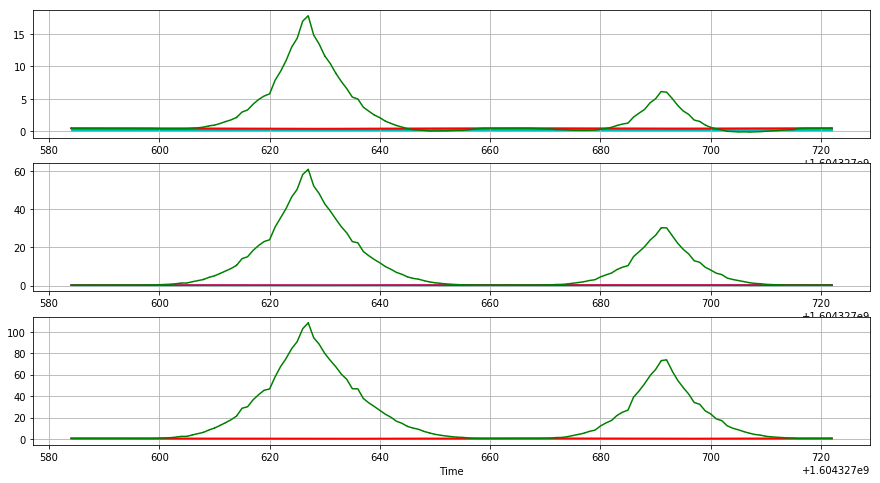

In [46]:
fig, axs = plt.subplots(3,figsize =(15,8))
plt.xlabel('Time')
axs[0].grid()
axs[1].grid()
axs[2].grid()


#Plot the predicted end effector prior"""""
axs[0].plot((tag_time_subsetbag1 ),ee_mean_prior_arr[:,0],c='b') 
axs[0].fill_between(tag_time_subsetbag1,ee_mean_prior_arr[:,0],ee_cov_all_prior[:,0], color='C')
axs[1].plot((tag_time_subsetbag1 ),ee_mean_prior_arr[:,1],c='b')
axs[1].fill_between(tag_time_subsetbag1,ee_mean_prior_arr[:,1],ee_cov_all_prior[:,1], color='C')
axs[2].plot((tag_time_subsetbag1),ee_mean_prior_arr[:,2],c='b')
axs[2].fill_between(tag_time_subsetbag1,ee_mean_prior_arr[:,2],ee_cov_all_prior[:,2], color='C')

#Plot vicon end effector using the aligned and interpolated
axs[0].plot((tag_time_subsetbag1),viconInRobotFrame_arr[:,0],c='r')
axs[1].plot((tag_time_subsetbag1),viconInRobotFrame_arr[:,1],c='r')
axs[2].plot((tag_time_subsetbag1),viconInRobotFrame_arr[:,2],c='r')

# # #Plot prosterior end effector
axs[0].plot(tag_time_subsetbag1,ee_mean_poster_arr[:,0],c='green') 
# #axs[0].fill_between(tag_time_subsetbag1,ee_mean_poster_arr[:,0],ee_cov_all_poster[:,0], color='lime')
axs[1].plot(tag_time_subsetbag1,ee_mean_poster_arr[:,1],c='green')
# #axs[1].fill_between(tag_time_subsetbag1,ee_mean_poster_arr[:,1],ee_cov_all_poster[:,1], color='lime')
axs[2].plot(tag_time_subsetbag1,ee_mean_poster_arr[:,2],c='green')
# #axs[2].fill_between(tag_time_subsetbag1,ee_mean_poster_arr[:,2],ee_cov_all_poster[:,2], color='lime')

plt.show()

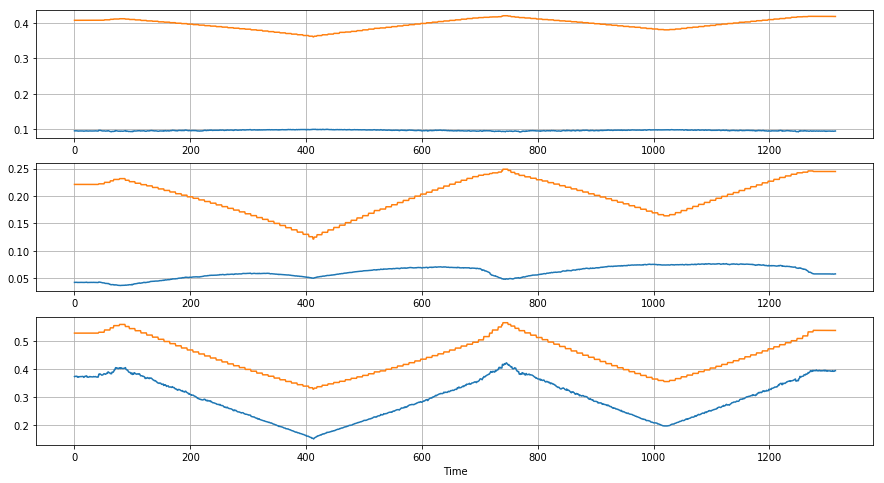

In [48]:
fig, axs = plt.subplots(3,figsize =(15,8))
plt.xlabel('Time')
axs[0].grid()
axs[1].grid()
axs[2].grid()

#Plot the predicted end effector prior"""""
axs[0].plot(markerTag_ee_subsetbag1[:,0]) 
axs[0].plot(viconInRobotFrame_arr[:,0]) 

axs[1].plot(markerTag_ee_subsetbag1[:,1]) 
axs[1].plot(viconInRobotFrame_arr[:,1]) 
axs[2].plot(markerTag_ee_subsetbag1[:,2]) 
axs[2].plot(viconInRobotFrame_arr[:,2]) 
plt.show()